# PyTorch Faster R-CNN

### Torch and TorchVision
https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn

https://pytorch.org/vision/stable/training_references.html

### COCO Images
https://cocodataset.org/#home

https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [1]:
import os
import time
import datetime
import shutil

from collections import defaultdict

from pycocotools.coco import COCO

import PIL
import cv2

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tqdm

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

try:
    from torchmetrics.detection.mean_ap import MeanAveragePrecision
except:
    !pip install torchmetrics
    from torchmetrics.detection.mean_ap import MeanAveragePrecision

import albumentations as A 
from albumentations.pytorch import ToTensorV2

date = str(datetime.date.today())

if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device("cpu")
     
print("Using {}.".format(device_name));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 7.4 MB/s eta 0:00:00
Using cpu.


## Download and Prepare COCO Images and Annotations

In [2]:
# Download image files.
#if "train2017.zip" not in os.listdir("./"):
#    !wget http://images.cocodataset.org/zips/train2017.zip
#    !unzip train.zip

In [3]:
# Download annotations files.
if "annotations_trainval2017.zip" not in os.listdir("./"):
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip annotations_trainval2017.zip

--2023-04-24 14:23:35--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.219.177, 52.217.107.172, 52.217.19.4, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.219.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.3MB/s    in 2.5s    

2023-04-24 14:23:37 (96.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [4]:
# Load the train and val annotations into memory.
train_ann_file = "./annotations/instances_{}.json".format("train2017")
val_ann_file = "./annotations/instances_{}.json".format("val2017")

train_coco = COCO(train_ann_file)
val_coco = COCO(val_ann_file)

loading annotations into memory...
Done (t=29.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [91]:
class COCO(torch.utils.data.Dataset):
    def __init__(self, coco, wanted_classes = ["person"], transforms = None):
        self.coco = coco
        self.cat_ids = self.coco.getCatIds(catNms = wanted_classes)
        self.img_ids = self.coco.getImgIds(catIds = self.cat_ids)
        self.coco_dicts = self.coco.loadImgs(self.img_ids)
        self.transforms = transforms
        
    def __getitem__(self, i):
        # Obtain the image from the internet.
        image = io.imread(self.coco_dicts[i].get("coco_url"))

        # Normalize the pixel values from [0, 255] to [0, 1]
        image = image / 255.0

        # Bounding boxes in MS COCO format.
        ann_ids = self.coco.getAnnIds(imgIds = self.coco_dicts[i].get("id"), catIds = self.cat_ids, iscrowd = None)
        anns = self.coco.loadAnns(ann_ids)

        target = {"bboxes" : np.array([a.get("bbox") for a in anns]), 
                  "categories" : [a.get("category_id") for a in anns]}

        if self.transforms:
            # Albumentations transforms.
            sample = self.transforms(image = image, 
                                     bboxes = target["bboxes"], 
                                     labels = target["categories"])
            
            image = sample["image"].to(torch.float32)
            target["bboxes"] = torch.Tensor(sample["bboxes"])

        # As bboxes are in the MS COCO format [x0, y0, w, h], we need to change them to the
        # PyTorch format [x0, y0, x1, y1].
        target["bboxes"][:, 3] = target["bboxes"][:, 1] + target["bboxes"][:, 3]   
        target["bboxes"][:, 2] = target["bboxes"][:, 0] + target["bboxes"][:, 2]
        
        return image, target

    def __len__(self):
        return len(self.img_ids)

In [92]:
bbox_params = {"format" : "coco", "label_fields" : ["labels"]}

def get_train_transform():
    return A.Compose([A.Blur(blur_limit = 3, p = 0.1), 
                      ToTensorV2(p = 1.0)], 
                      bbox_params = bbox_params)

def get_valid_transform():
    return A.Compose([ToTensorV2(p = 1.0)], 
                      bbox_params = bbox_params)

def collate_fn(batch):
    return tuple(zip(*batch))

In [93]:
CLASS_NAME = ["__background__", "person"]
NUM_CLASSES = len(CLASS_NAME)
BATCH_SIZE = 8

train_dataset = COCO(train_coco, CLASS_NAME[1:], get_train_transform())
valid_dataset = COCO(val_coco, CLASS_NAME[1:], get_valid_transform())

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size = BATCH_SIZE, 
                                           shuffle = True, 
                                           collate_fn = collate_fn)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size = BATCH_SIZE, 
                                           shuffle = False,
                                           collate_fn = collate_fn)

print("Train DL: {}, valid DL: {}.".format(len(train_loader),len(valid_loader)))

Train DL: 8015, valid DL: 337.


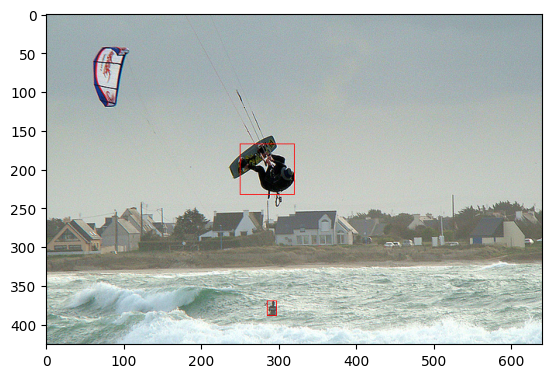

In [98]:
# Try out the dataloaders to make sure that they are working correctly!
x = next(iter(valid_loader))
i = x[0][0].permute(1, 2, 0).numpy().astype(float)
for b in x[1][0]["bboxes"]:
    cv2.rectangle(i, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), color = [1, 0, 0])
plt.imshow(i)
plt.show()

In [ ]:
def unbatch(data, device):
    images, targets = data
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets

def train(train_data_loader, model, train_itr, train_loss_list, device):
    model.to(device)
    model.train()
    
    print('Training...')
    prog_bar = tqdm.tqdm(train_data_loader, total = len(train_data_loader))
    for i, data in enumerate(prog_bar):
        images, targets = unbatch(data, device)
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)

        train_itr = train_itr + 1
        prog_bar.set_description(desc = "Loss: {:.3f}".format(loss_value))
        
    return train_itr, train_loss_list

def validate(valid_data_loader, model, val_itr, val_loss_list, device):
    model.to(device)
    model.train() # Train mode to obtain the loss values.
    
    print('Validating...')
    prog_bar = tqdm.tqdm(valid_data_loader, total = len(valid_data_loader))  
    for i, data in enumerate(prog_bar):
        images, targets = unbatch(data, device)
        
        # Remember to set torch.no_grad() to prevent any gradient updates!!!
        with torch.no_grad():
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        
        val_itr = val_itr + 1
        prog_bar.set_description(desc = "Loss: {:.3f}".format(loss_value))
        
    return val_itr, val_loss_list

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations = self.iterations + 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss = float('inf')):
        self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, 
                 output_file_name = '/kaggle/working/best_model_{}.pth'.format(date)):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            
            sys.stdout.write("\nBest validation loss: {:.3f} for epoch {}.\n".format(self.best_valid_loss, epoch+1));
            
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()}, 
                        output_file_name)

def save_model(epoch, model, optimizer, 
               output_file_name = '/kaggle/working/last_model_{}.pth'.format(date)):
    torch.save({'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, 
                output_file_name)

In [ ]:
def get_fasterrcnn(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = "DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [ ]:
# Define FasterRCNN model.
model = get_fasterrcnn(num_classes = NUM_CLASSES)

params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(params, lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
#optimizer = torch.optim.SGD(params, lr = 0.0001)
optimizer = torch.optim.Adam(params, lr = 0.001) # Adam is very slow compared to SGD.

In [ ]:
# Prepare for training. Containers to hold all sorts of data.
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

save_best_model = SaveBestModel()

In [ ]:
# Number of training epochs.
NUM_EPOCHS = 10

In [ ]:
# Training-validation iterations.

emergency_stop = False # For emergency stopping such as NaN occurence.
for epoch in range(NUM_EPOCHS):
    sys.stdout.write("\nEPOCH {} of {}.".format(epoch + 1, NUM_EPOCHS));
    # Reset the loss history for each iteration.
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    # Train loop.
    train_loss = train(train_loader, model, train_itr, train_loss_list, device = device_name)
    # Validation loop.
    val_loss = validate(valid_loader, model, val_itr, val_loss_list, device = device_name)
    sys.stdout.write("Epoch #{} train loss: {:.3f}, validation loss: {:.3f}".format(epoch + 1, 
                                                                                    train_loss_hist.value, 
                                                                                    val_loss_hist.value));
    
    # After each iteration, check for NaNs in the model parameters.
    # If NaNs exist, stop immediately.
    model_parameters = [p.detach().to(torch.device("cpu")).numpy() for p in model.parameters()];
    for i in range(len(model_parameters)):
        whereisnan = np.where(np.isnan(model_parameters[i]))
        lenwhereisnan = [len(w) for w in whereisnan]
        if np.sum(lenwhereisnan) > 0:
            #print(i, whereisnan[0])
            emergency_stop = True
            break
    if emergency_stop == True:
        break
    
    # If not, save the best model to disk for each iteration.
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    save_model(epoch, model, optimizer)


EPOCH 1 of 10.Training...

Loss: 0.536: 100%|██████████| 500/500 [06:58<00:00,  1.20it/s]


Validating...

Loss: 0.748: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #1 train loss: 0.683, validation loss: 0.565
Best validation loss: 0.565 for epoch 1.

EPOCH 2 of 10.Training...

Loss: 0.526: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Validating...

Loss: 0.629: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #2 train loss: 0.482, validation loss: 0.463
Best validation loss: 0.463 for epoch 2.

EPOCH 3 of 10.Training...

Loss: 0.339: 100%|██████████| 500/500 [06:58<00:00,  1.20it/s]


Validating...

Loss: 0.611: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch #3 train loss: 0.427, validation loss: 0.455
Best validation loss: 0.455 for epoch 3.

EPOCH 4 of 10.Training...

Loss: 0.382: 100%|██████████| 500/500 [06:58<00:00,  1.19it/s]


Validating...

Loss: 0.580: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #4 train loss: 0.398, validation loss: 0.466
EPOCH 5 of 10.Training...

Loss: 0.341: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Validating...

Loss: 0.555: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #5 train loss: 0.378, validation loss: 0.389
Best validation loss: 0.389 for epoch 5.

EPOCH 6 of 10.Training...

Loss: 0.497: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Validating...

Loss: 0.508: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #6 train loss: 0.367, validation loss: 0.386
Best validation loss: 0.386 for epoch 6.

EPOCH 7 of 10.Training...

Loss: 0.514: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Validating...

Loss: 0.540: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #7 train loss: 0.353, validation loss: 0.404
EPOCH 8 of 10.Training...

Loss: 0.320: 100%|██████████| 500/500 [06:58<00:00,  1.19it/s]


Validating...

Loss: 0.454: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch #8 train loss: 0.351, validation loss: 0.394
EPOCH 9 of 10.Training...

Loss: 0.251: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Validating...

Loss: 0.505: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Epoch #9 train loss: 0.342, validation loss: 0.387
EPOCH 10 of 10.Training...

Loss: 0.349: 100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


Validating...

Loss: 0.515: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Epoch #10 train loss: 0.338, validation loss: 0.395

In [ ]:
# Visualizing model outputs.
"""
detection_threshold = 0.8
data = next(iter(test_loader))

img, tgt = data
images = list(image.to(device_name) for image in images)
targets = [{k: v.to(device_name) for k, v in t.items()} for t in targets]
model.to(device_name)
model.eval()
predictions = model(images)

for i in range(len(predictions)):
    want = predictions[i]["scores"] >= detection_threshold
    predictions[i]["boxes"] = predictions[i]["boxes"][want]
    predictions[i]["labels"] = predictions[i]["labels"][want]
    predictions[i]["scores"] = predictions[i]["scores"][want]
""";

In [ ]:
"""
color_picker = ["k", "r", "g", "b"]

for i, p in zip(images, predictions):
    img = i.permute(1, 2, 0).detach().to(torch.device("cpu")).numpy()
    fig, ax = plt.subplots(figsize = [3, 3])
    ax.imshow(img)
    for l, b in zip(p["labels"], p["boxes"]):
        b = b.detach().to(torch.device("cpu")).numpy()
        l = l.item()
        rect = patches.Rectangle(b[:2], (b[2] - b[0]), (b[3] - b[1]), linewidth = 1, 
                                 edgecolor = color_picker[l], facecolor = "none")
        ax.add_patch(rect)
    plt.show()
""";

In [ ]:
# Test set evaluation.
detection_threshold = 0.8

#image_list = []
prediction_list = []
label_list = []

losses = []

count = 0
prog_bar = tqdm.tqdm(test_loader, total = len(test_loader))  
for data in prog_bar:
    images, targets = data
    images = list(image.to(device_name) for image in images)
    targets = [{k: v.to(device_name) for k, v in t.items()} for t in targets]
    
    model.to(device_name)
    
    model.eval()
    output = model(images) # This is a list of dicts, just like targets.
    
    model.train()
    loss_dict = model(images, targets)
    batch_loss = sum(loss for loss in loss_dict.values())
    losses.append(batch_loss.item())
    
    if detection_threshold is not None:
        for i in range(len(output)):
            want = output[i]["scores"] >= detection_threshold
            output[i]["boxes"] = output[i]["boxes"][want].detach().to(torch.device("cpu"))
            output[i]["labels"] = output[i]["labels"][want].detach().to(torch.device("cpu"))
            output[i]["scores"] = output[i]["scores"][want].detach().to(torch.device("cpu"))
    
    #image_list += images # This will cause memory usage to explode!
    prediction_list += output
    label_list += [{k: v.to(torch.device("cpu")) for k, v in t.items()} for t in targets]
    
    count = count + 1
    
    #if count > 0: # For some stupid reason, kernel may crashes after 30 iterations...
    #    break
    
    prog_bar.set_description(desc = "Current loss: {:.4f}".format(np.mean(losses)))

Current loss: 0.3858: 100%|██████████| 500/500 [01:02<00:00,  8.04it/s]


In [ ]:
mAP = MeanAveragePrecision()
mAP.update(prediction_list, label_list)

In [ ]:
sys.stdout.write("Mean test loss: {:.3f}.".format(np.mean(losses)));

Mean test loss: 0.386.

In [ ]:
sys.stdout.write(str(mAP.compute()));

{'map': tensor(0.4489), 'map_50': tensor(0.7689), 'map_75': tensor(0.4868), 'map_small': tensor(0.3990), 'map_medium': tensor(0.4725), 'map_large': tensor(0.2514), 'mar_1': tensor(0.1345), 'mar_10': tensor(0.4927), 'mar_100': tensor(0.5120), 'mar_small': tensor(0.4582), 'mar_medium': tensor(0.5750), 'mar_large': tensor(0.2793), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}